# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
#if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    #!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "../mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 0


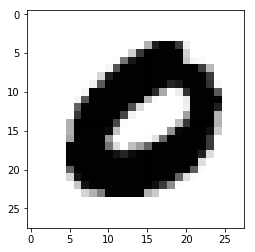

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys');

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g
        
        # TODO
        self.d(self.backptr, self.gradient)
        if not(self.backptr):
            for backptr in self.backptr:
                if not isinstance(backptr, Parameter) and isinstance(backptr, Tensor):
                    backptr.backward()
        else :
            return
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        self.gamma = np.zeros_like(self.data)
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x):
    # TODO
    data = np.tanh(x.data)
    result = Tensor(data,x.require_grad)
    result.d = backward_tanh
    result.backptr = [x]
    return result

def backward_tanh(backptr, g):
    # TODO
    x, = backptr
    if x.require_grid:
        x.accumulate_gradient(g * (1 - np.power(tanh(x).data, 2)))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    # TODO
    data = W.data @ x.data + b.data
    
    result = Tensor(data, any_require_grad([W, b, x]))
    result.d = backward_affine_transform
    result.backptr = [W, b, x]
    
    return result


def backward_affine_transform(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1, 1) @ x.data.reshape(1, -1)) # TODO
    if b.require_grad:
        b.accumulate_gradient(g) # TODO
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(g @ W.data) # TODO

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    # TODO
    b = max(x)
    y = np.exp(x - b)
    return y / y.sum()


def nll(x, gold):
    # TODO
    data = -x.data[gold] + np.log((np.exp(x.data)).sum())
    result = Tensor(data, require_grad=x.require_grad)
    result.d = backward_nll
    result.backptr = [x]
    return result


def backward_nll(backptr, gold_label, g):
    #TODO
    x, = backptr
    
    if x.require_grad:
        g_x = _softmax(x.data)
        
        g_x[gold_label]-= 1
        x.accumulate_gradient(g * g_x)
        x.backward()

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    # TODO
    initialization_range = np.sqrt(6.0 / (W.shape[0] + W.shape[1]))
    W[:] = np.random.uniform(low = -initialization_range, high = initialization_range, size = W.shape)

# Look at slides for the formula!
def kaiming_init(W):
    # TODO
    initialization_range = np.sqrt(6.0 / W.shape[1])
    W[:] = np.random.uniform(low = -initialization_range, high = initialization_range, size = W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)))
        self.b = Parameter(np.ndarray((dim_output,)))
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)        
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def calc_accuracy(data, network):
    s = 0
    for i in range(len(dev_data[0])):
        d = data[0][i]
        l = data[1][i]
        tensor = network.forward(Tensor(d))
        if (np.argmax(tensor.data) == l):
            s += 1
    
    return s / len(data[0])

In [16]:
def grad_reinit(data, network):
    s = 0
    for i in range(len(data[0])):
        d = data[0][i]
        l = data[1][i]                        

        tensor = network.forward(Tensor(d))
        loss = nll(tensor, l)

        optimizer.zero_grad()
        backward_nll(loss.backptr, l , g=1.)
        optimizer.step()

        if(np.argmax(tensor.data) == l):
            s += 1
    
    return s / len(data[0])

In [17]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    # TODO!
    # almost the same as last week
    dev_a = []
    train_a = []
 
    train_a.append(calc_accuracy(train_data, network)) 
    dev_a.append(calc_accuracy(dev_data, network))

    for _ in range(n_epochs):
        train_accuracy = grad_reinit(train_data, network)
        dev_a.append(calc_accuracy(dev_data, network))
        train_a.append(train_accuracy)

    
    return dev_a, train_a

In [18]:
def plotter(y1, y2, label1, label2, xlabel, ylabel):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.plot([i for i in range(len(y1))], y1, label = label1);
    plt.plot([i for i in range(len(y2))], y2, label = label2);
    plt.legend(loc="best")

Accurancy on Test Dataset is 0.9157.


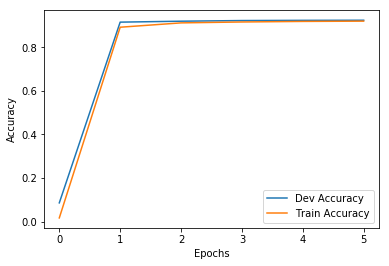

In [19]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

dev, train = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

plotter(dev, train, "Dev Accuracy", "Train Accuracy", "Epochs", "Accuracy");

print("Accurancy on Test Dataset is {}.".format(calc_accuracy(test_data, network)))

After you finished the linear network, you can move to a deep network!

In [20]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, Tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        
        # TODO...
        if Tanh:
            self.activation_function = tanh
        else:
            self.activation_function = relu
        
        for i in range(n_layers):
            self.W.append(Parameter(np.ndarray((hidden_dim, dim_input))))
            self.b.append(Parameter(np.ndarray((hidden_dim))))
            
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim))) 
        self.output_bias = Parameter(np.ndarray((dim_output)))
        
        self.init_parameters(Tanh)
        
    def init_parameters(self, Tanh):
        # TODO...
        glorot_init(self.output_proj.data)
        zero_init(self.output_proj.data)
            
        if Tanh:
            for W in self.W:
                glorot_init(W.data)
        else: 
            for W in self.W:
                kaiming_init(W.data)
                
        for b in self.b:
            zero_init(b.data)

    def forward(self, x):
        # TODO
        res = x
        for W, b in zip(self.W , self.b):
            res = affine_transform(W, b, res)
            res = self.activation_function(res)

        res = affine_transform(self.output_proj, self.output_bias, res)
        return res

Accurancy on Test Dataset is 0.8646.


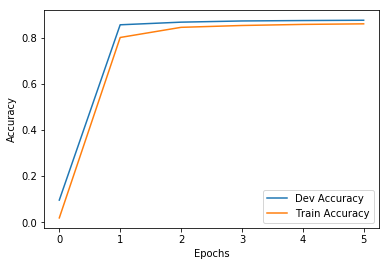

In [21]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1)
optimizer = SGD(network.parameters(), 0.01)

dev, train = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

plotter(dev, train, "Dev Accuracy", "Train Accuracy", "Epochs", "Accuracy");

print("Accurancy on Test Dataset is {}.".format(calc_accuracy(test_data, network)))

# Bonus

You can try to implement a momentum SGD optimizer!
Note that you have to keep track of the velocity for each parameter in the optimizer.

In [22]:
# simple gradient descent optimizer
class SGD_optimizer:
    def __init__(self, params, eps, mu):
        self.params = params
        self.eps = eps
        self.mu = mu 
        
        
    def step(self):
        for p in self.params:
            p.gamma[:] = self.mu*p.gamma + p.gradient
            p.data[:] = p.data - self.eps* p.gamma

        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

Accurancy on Test Dataset is 0.8966.


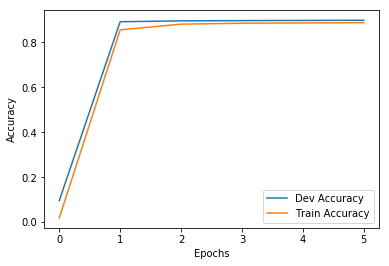

In [23]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, Tanh=True)
optimizer = SGD_optimizer(network.parameters(), 0.01, 0.5)

dev, train = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

plotter(dev, train, "Dev Accuracy", "Train Accuracy", "Epochs", "Accuracy");

print("Accurancy on Test Dataset is {}.".format(calc_accuracy(test_data, network)))